#### Import data set

In [1]:
import numpy as np
import pandas as pd

df = pd.read_csv('train.csv')

#### Split data into train and test datasets

In [2]:
from sklearn.model_selection import train_test_split

train, test = train_test_split(df, test_size=0.2)
print('train: %s' % len(train))
print('test: %s' % len(test))

train: 33892
test: 8473


#### Vectorize queries

In [3]:
# sample query data
list(train['query'][:10])

['Modern warfare 3',
 'Rock smith',
 'xbox',
 'Battlefield 3',
 'Gears of war 3',
 'midnight club',
 'Ps3',
 'ghost recon',
 'Rocksmith',
 'Forza motorsport']

In [4]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity

vectorizer = TfidfVectorizer()
tfidf = vectorizer.fit_transform(list(train['query']))

#### Find best K for clustering

In [5]:
from sklearn.cluster import KMeans
from matplotlib import pyplot as plt

distorsions = {}
k = 500
while k <= 3000:
    model = KMeans(n_clusters=k, max_iter=1000, n_init=1)
    model.fit(tfidf)
    distorsions[k] = model.inertia_
    k += 500

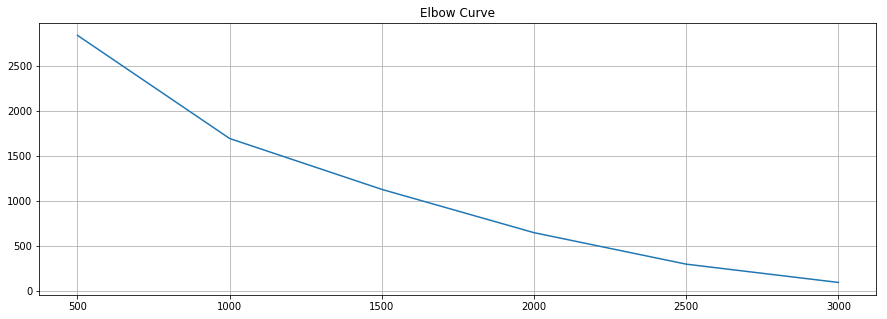

In [6]:
fig = plt.figure(figsize=(15, 5))
plt.plot(distorsions.keys(), distorsions.values())
plt.title('Elbow Curve')
plt.grid(True)

In [7]:
# best K = 3495
k = 3495
model = KMeans(n_clusters=k, max_iter=1000)
model.fit(tfidf)
print("k:", k, " cost:", model.inertia_)

k: 3495  cost: 0.9232743223306629


#### Select top-n skus for each cluster

In [11]:
# create 'cluster' column
train['cluster'] = model.predict(vectorizer.transform(list(train['query'])))

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [15]:
top_n = 1
m = pd.crosstab(train['cluster'], train['sku'])
train_top = pd.DataFrame({n: m.T[column].nlargest(top_n).index.tolist() for n, column in enumerate(m.T)}).T

In [16]:
train_top

,0
0,2712876
1,9854804
2,2541184
3,2945052
4,2173065
5,2078113
6,2953607
7,2107458
8,2704058
9,2856517


#### Test model on test dataset

In [21]:
# create 'cluster' column
test['cluster'] = model.predict(vectorizer.transform(list(test['query'])))

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [98]:
# get the top sku for each cluster
predictions = pd.DataFrame(train_top.iloc[test['cluster']])
predictions = predictions.rename(index=str, columns={0: "sku"})

In [103]:
predictions

,sku
515,1580049
36,2078113
2,2541184
44,8237302
115,3046066
2073,2467183
59,2945052
7,2107458
12,2758085
25,2095189


In [110]:
# check result
number_of_matched_skus = 0
for test_sku, pred_sku in zip(test.sku, predictions.sku):
    if test_sku == pred_sku:
        number_of_matched_skus += 1
        
print('matched: ' + str(round(number_of_matched_skus / len(test) * 100, 2)) + '%')

matched: 63.5%
